<a href="https://colab.research.google.com/github/ykato27/Darts/blob/main/Time_Series_Analysis_Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ライブラリー「Darts」を使った時系列分析

In [ ]:
# 必要なライブラリーのインポート
import darts
from darts import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [ ]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('AirPassengers.csv')
# データの中身を確認
df.head()

,Month,#Passengers
0,Jan-49,112
1,Feb-49,118
2,Mar-49,132
3,Apr-49,129
4,May-49,121


In [ ]:
# DartsのTimeSeriesに変換
series = TimeSeries.from_dataframe(df, time_col='Month', value_cols='#Passengers')

Text(0.5, 0, 'Year')

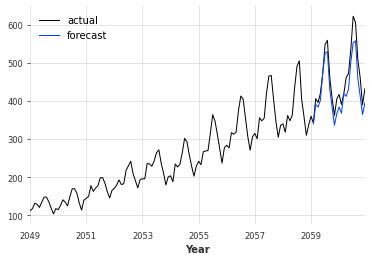

In [ ]:
# Jan-59以前と以後に分割
train, val = series.split_after(pd.Timestamp('Jan-59'))
from darts.models import ExponentialSmoothing

# モデル生成
model_es = ExponentialSmoothing()
# 学習
model_es.fit(train) 
# 予測 (predictには予測数を入れることに注意)
historical_fcast_es = model_es.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
historical_fcast_es.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

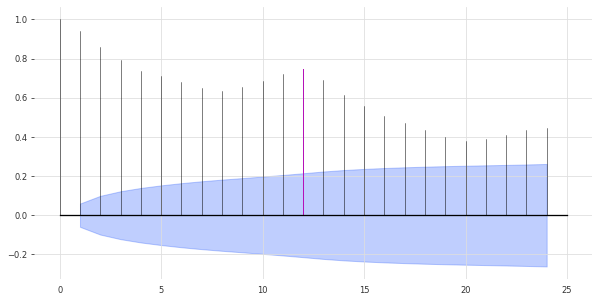

In [ ]:
plot_acf(train, m = 12, alpha = .05)

Text(0.5, 0, 'Year')

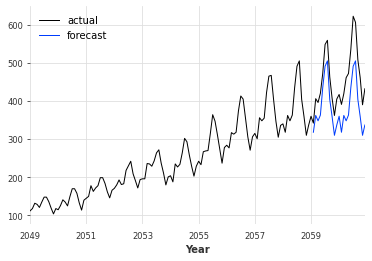

In [ ]:
# NaiveSeasonal
from darts.models import NaiveSeasonal
# モデル生成
seasonal_model = NaiveSeasonal(K=12)
# 学習
seasonal_model.fit(train)
# 予測
seasonal_forecast = seasonal_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
seasonal_forecast.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

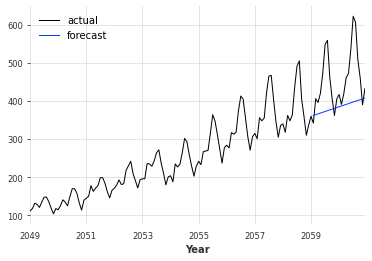

In [ ]:
# NaiveDrift
from darts.models import NaiveDrift
# モデル生成
drift_model = NaiveDrift()
# 学習
drift_model.fit(train) 
# 予測
drift_forecast = drift_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
drift_forecast.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

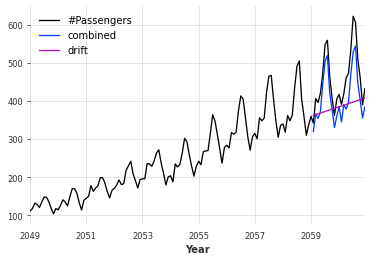

In [ ]:
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

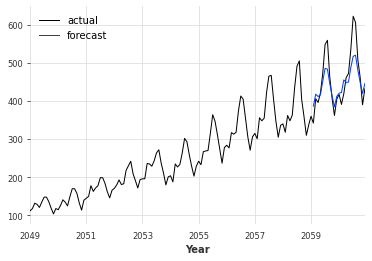

In [ ]:
# Prophet
from darts.models import Prophet
# モデル生成
model_P = Prophet()
# 学習
model_P.fit(train) 
# 予測
prediction = model_P.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
prediction.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [ ]:
# Search for the best theta parameter, by trying 50 different values
# Theta
from darts.models import Theta
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

Text(0.5, 0, 'Year')

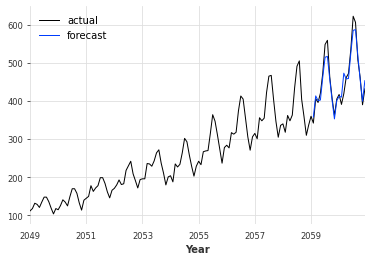

In [ ]:
# Theta
# モデル生成
best_theta_model = Theta(best_theta)
# 学習
best_theta_model.fit(train) 
# 予測
pred_best_theta = best_theta_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
pred_best_theta.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [ ]:
#Transformer Model
from darts.models import TransformerModel

# Normalize the time series 
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [ ]:
N_EPOCHS = 1000
NR_EPOCHS_VALIDATION_PERIOD = 10

# Number of previous time stamps taken into account.
SEQ_LENGTH = 10
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of layers in encoder/decoder
NUM_LAYERS = 6

my_model = TransformerModel(
    batch_size = 32,
    input_length = SEQ_LENGTH,
    input_size = 1,
    output_length = OUTPUT_LEN,
    output_size = 1,
    n_epochs = N_EPOCHS,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = NR_EPOCHS_VALIDATION_PERIOD,
    model = None,
    d_model = 64,
    nhead = 32,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    dim_feedforward = 2048,
    dropout = 0.1,
    activation = "relu",
    custom_encoder = None,
    custom_decoder = None,
    random_state=42,
)

In [ ]:
my_model.fit(training_series=train_scaled, val_training_series=val_scaled, verbose=True)

  0%|          | 1/1000 [00:02<40:20,  2.42s/it]

  1%|          | 11/1000 [00:22<33:09,  2.01s/it]

  2%|▏         | 21/1000 [00:42<32:28,  1.99s/it]

  3%|▎         | 31/1000 [01:01<31:12,  1.93s/it]

  4%|▍         | 41/1000 [01:22<33:31,  2.10s/it]

  5%|▌         | 51/1000 [01:42<32:24,  2.05s/it]

  6%|▌         | 61/1000 [02:02<31:27,  2.01s/it]

  7%|▋         | 71/1000 [02:22<32:03,  2.07s/it]

  8%|▊         | 81/1000 [02:42<31:04,  2.03s/it]

  9%|▉         | 91/1000 [03:03<31:35,  2.09s/it]

 10%|█         | 101/1000 [03:23<30:24,  2.03s/it]

 11%|█         | 111/1000 [03:43<30:11,  2.04s/it]

 12%|█▏        | 121/1000 [04:04<30:07,  2.06s/it]

 13%|█▎        | 131/1000 [04:24<29:39,  2.05s/it]

 14%|█▍        | 141/1000 [04:44<28:56,  2.02s/it]

 15%|█▌        | 151/1000 [05:05<29:32,  2.09s/it]

 16%|█▌        | 161/1000 [05:25<28:35,  2.05s/it]

 17%|█▋        | 171/1000 [05:46<28:42,  2.08s/it]

 18%|█▊        | 181/1000 [06:06<28:13,  2.07s/it]

 19%|█▉        | 191/1000 [06:26<28:07,  2.09s/it]

 20%|██        | 201/1000 [06:47<28:02,  2.11s/it]

 21%|██        | 211/1000 [07:07<26:53,  2.05s/it]

 22%|██▏       | 221/1000 [07:27<25:42,  1.98s/it]

 23%|██▎       | 231/1000 [07:47<25:51,  2.02s/it]

 24%|██▍       | 241/1000 [08:07<25:38,  2.03s/it]

 25%|██▌       | 251/1000 [08:27<24:33,  1.97s/it]

 26%|██▌       | 261/1000 [08:47<24:53,  2.02s/it]

 27%|██▋       | 271/1000 [09:07<24:01,  1.98s/it]

 28%|██▊       | 281/1000 [09:27<24:01,  2.00s/it]

 29%|██▉       | 291/1000 [09:46<23:22,  1.98s/it]

 30%|███       | 301/1000 [10:06<23:43,  2.04s/it]

 31%|███       | 311/1000 [10:26<23:03,  2.01s/it]

 32%|███▏      | 321/1000 [10:46<22:52,  2.02s/it]

 33%|███▎      | 331/1000 [11:07<23:12,  2.08s/it]

 34%|███▍      | 341/1000 [11:27<22:21,  2.04s/it]

 35%|███▌      | 351/1000 [11:46<21:39,  2.00s/it]

 36%|███▌      | 361/1000 [12:06<21:18,  2.00s/it]

 37%|███▋      | 371/1000 [12:26<20:50,  1.99s/it]

 38%|███▊      | 381/1000 [12:46<21:17,  2.06s/it]

 39%|███▉      | 391/1000 [13:06<21:08,  2.08s/it]

 40%|████      | 401/1000 [13:26<20:06,  2.01s/it]

 41%|████      | 411/1000 [13:46<19:27,  1.98s/it]

 42%|████▏     | 421/1000 [14:06<19:13,  1.99s/it]

 43%|████▎     | 431/1000 [14:26<18:40,  1.97s/it]

 44%|████▍     | 441/1000 [14:46<18:57,  2.03s/it]

 45%|████▌     | 451/1000 [15:06<18:33,  2.03s/it]

 46%|████▌     | 461/1000 [15:26<18:19,  2.04s/it]

 47%|████▋     | 471/1000 [15:47<17:43,  2.01s/it]

 48%|████▊     | 481/1000 [16:07<17:33,  2.03s/it]

 49%|████▉     | 491/1000 [16:27<16:43,  1.97s/it]

 50%|█████     | 501/1000 [16:47<16:53,  2.03s/it]

 51%|█████     | 511/1000 [17:07<16:12,  1.99s/it]

 52%|█████▏    | 521/1000 [17:27<16:05,  2.02s/it]

 53%|█████▎    | 531/1000 [17:47<15:25,  1.97s/it]

 54%|█████▍    | 541/1000 [18:07<15:19,  2.00s/it]

 55%|█████▌    | 551/1000 [18:27<14:42,  1.97s/it]

 56%|█████▌    | 561/1000 [18:47<14:59,  2.05s/it]

 57%|█████▋    | 571/1000 [19:07<14:46,  2.07s/it]

 58%|█████▊    | 581/1000 [19:27<13:45,  1.97s/it]

 59%|█████▉    | 591/1000 [19:47<13:28,  1.98s/it]

 60%|██████    | 601/1000 [20:07<13:20,  2.01s/it]

 61%|██████    | 611/1000 [20:27<13:15,  2.05s/it]

 62%|██████▏   | 621/1000 [20:47<12:46,  2.02s/it]

 63%|██████▎   | 631/1000 [21:07<12:37,  2.05s/it]

 64%|██████▍   | 641/1000 [21:28<12:11,  2.04s/it]

 65%|██████▌   | 651/1000 [21:48<11:50,  2.04s/it]

 66%|██████▌   | 661/1000 [22:08<11:09,  1.97s/it]

 67%|██████▋   | 671/1000 [22:28<11:13,  2.05s/it]

 68%|██████▊   | 681/1000 [22:47<10:34,  1.99s/it]

 69%|██████▉   | 691/1000 [23:08<10:26,  2.03s/it]

 70%|███████   | 701/1000 [23:28<10:05,  2.02s/it]

 71%|███████   | 711/1000 [23:48<09:33,  1.99s/it]

 72%|███████▏  | 721/1000 [24:08<09:31,  2.05s/it]

 73%|███████▎  | 731/1000 [24:28<09:01,  2.01s/it]

 74%|███████▍  | 741/1000 [24:48<08:35,  1.99s/it]

 75%|███████▌  | 751/1000 [25:08<08:09,  1.97s/it]

 76%|███████▌  | 761/1000 [25:28<08:02,  2.02s/it]

 77%|███████▋  | 771/1000 [25:48<07:41,  2.02s/it]

 78%|███████▊  | 781/1000 [26:09<07:24,  2.03s/it]

 79%|███████▉  | 791/1000 [26:29<07:11,  2.06s/it]

 80%|████████  | 801/1000 [26:49<06:41,  2.02s/it]

 81%|████████  | 811/1000 [27:09<06:14,  1.98s/it]

 82%|████████▏ | 821/1000 [27:29<06:01,  2.02s/it]

 83%|████████▎ | 831/1000 [27:49<05:32,  1.97s/it]

 84%|████████▍ | 841/1000 [28:09<05:17,  2.00s/it]

 85%|████████▌ | 851/1000 [28:30<04:59,  2.01s/it]

 86%|████████▌ | 861/1000 [28:50<04:35,  1.99s/it]

 87%|████████▋ | 871/1000 [29:10<04:30,  2.09s/it]

 88%|████████▊ | 881/1000 [29:31<03:59,  2.01s/it]

 89%|████████▉ | 891/1000 [29:51<03:47,  2.09s/it]

 90%|█████████ | 901/1000 [30:11<03:15,  1.98s/it]

 91%|█████████ | 911/1000 [30:31<03:00,  2.03s/it]

 92%|█████████▏| 921/1000 [30:51<02:40,  2.03s/it]

 93%|█████████▎| 931/1000 [31:11<02:22,  2.06s/it]

 94%|█████████▍| 941/1000 [31:31<01:58,  2.01s/it]

 95%|█████████▌| 951/1000 [31:52<01:38,  2.00s/it]

 96%|█████████▌| 961/1000 [32:12<01:18,  2.02s/it]

 97%|█████████▋| 971/1000 [32:32<00:59,  2.04s/it]

 98%|█████████▊| 981/1000 [32:53<00:38,  2.05s/it]

 99%|█████████▉| 991/1000 [33:13<00:18,  2.01s/it]

100%|██████████| 1000/1000 [33:31<00:00,  2.01s/it]


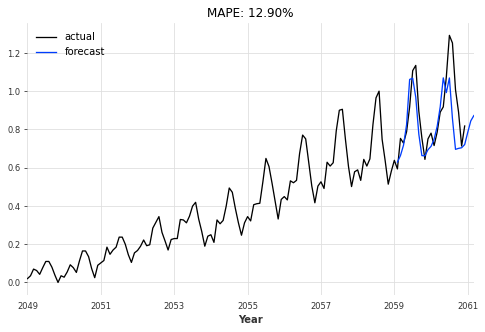

In [ ]:
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_series)))
    plt.legend()
    plt.xlabel('Year')
    
eval_model(my_model, 26, series_scaled, val_scaled)

In [ ]:
# LSTM
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

LSTM_model = RNNModel(
    model='LSTM',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42
)

In [ ]:
LSTM_model.fit(train_scaled, val_training_series=val_scaled, verbose=True)

  1%|          | 4/400 [00:00<00:20, 19.00it/s]

  3%|▎         | 13/400 [00:00<00:21, 18.35it/s]

  6%|▌         | 23/400 [00:01<00:19, 18.91it/s]

  8%|▊         | 33/400 [00:01<00:19, 19.02it/s]

 11%|█         | 44/400 [00:02<00:18, 19.53it/s]

 14%|█▎        | 54/400 [00:02<00:18, 18.58it/s]

 16%|█▌        | 64/400 [00:03<00:18, 17.91it/s]

 18%|█▊        | 74/400 [00:03<00:17, 18.59it/s]

 21%|██        | 84/400 [00:04<00:16, 18.66it/s]

 24%|██▎       | 94/400 [00:05<00:16, 18.66it/s]

 26%|██▌       | 104/400 [00:05<00:16, 18.26it/s]

 28%|██▊       | 114/400 [00:06<00:15, 18.93it/s]

 31%|███       | 124/400 [00:06<00:14, 18.51it/s]

 34%|███▎      | 134/400 [00:07<00:13, 19.36it/s]

 36%|███▌      | 144/400 [00:07<00:13, 18.98it/s]

 38%|███▊      | 153/400 [00:08<00:12, 19.23it/s]

 41%|████      | 163/400 [00:08<00:12, 19.15it/s]

 43%|████▎     | 173/400 [00:09<00:12, 18.78it/s]

 46%|████▌     | 183/400 [00:09<00:12, 18.06it/s]

 48%|████▊     | 193/400 [00:10<00:11, 18.27it/s]

 51%|█████     | 203/400 [00:10<00:10, 19.18it/s]

 53%|█████▎    | 213/400 [00:11<00:09, 19.15it/s]

 56%|█████▌    | 223/400 [00:11<00:09, 18.41it/s]

 58%|█████▊    | 233/400 [00:12<00:08, 19.03it/s]

 61%|██████    | 243/400 [00:13<00:08, 19.15it/s]

 63%|██████▎   | 253/400 [00:13<00:07, 18.40it/s]

 66%|██████▌   | 263/400 [00:14<00:07, 19.01it/s]

 68%|██████▊   | 273/400 [00:14<00:07, 17.96it/s]

 71%|███████   | 283/400 [00:15<00:06, 18.44it/s]

 73%|███████▎  | 293/400 [00:15<00:05, 18.01it/s]

 76%|███████▌  | 303/400 [00:16<00:05, 18.99it/s]

 78%|███████▊  | 313/400 [00:16<00:04, 18.05it/s]

 81%|████████  | 323/400 [00:17<00:04, 19.05it/s]

 83%|████████▎ | 333/400 [00:17<00:03, 18.56it/s]

 86%|████████▌ | 343/400 [00:18<00:02, 19.17it/s]

 88%|████████▊ | 353/400 [00:18<00:02, 19.04it/s]

 91%|█████████ | 363/400 [00:19<00:01, 19.29it/s]

 93%|█████████▎| 373/400 [00:19<00:01, 18.88it/s]

 96%|█████████▌| 384/400 [00:20<00:00, 19.29it/s]

 99%|█████████▉| 395/400 [00:21<00:00, 18.28it/s]

100%|██████████| 400/400 [00:21<00:00, 18.65it/s]


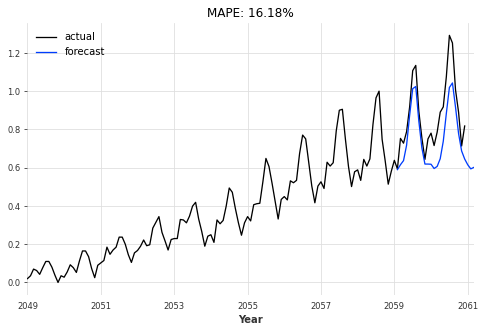

In [ ]:
eval_model(LSTM_model, 26, series_scaled, val_scaled)

loading model_best_260.pth.tar


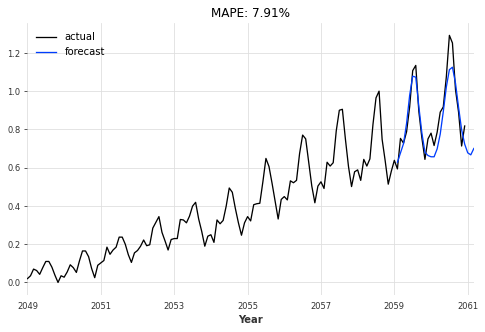

In [ ]:
bestLSTM_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(bestLSTM_model, 26, series_scaled, val_scaled)

In [ ]:
# GRU
gru_model = RNNModel(
    model='GRU',
    output_length=OUTPUT_LEN*4,
    input_length=SEQ_LENGTH,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    batch_size=64,
    n_epochs=1500,
    dropout=0.2,
    model_name='Air_GRU_out12',
    log_tensorboard=True,
    random_state=42
)

In [ ]:
gru_model.fit(train_scaled, val_training_series=val_scaled, verbose=True)

  0%|          | 4/1500 [00:00<00:46, 32.28it/s]

  1%|          | 16/1500 [00:00<00:46, 32.13it/s]

  2%|▏         | 28/1500 [00:00<00:42, 35.04it/s]

  2%|▏         | 36/1500 [00:01<00:42, 34.30it/s]

  3%|▎         | 44/1500 [00:01<00:43, 33.55it/s]

  4%|▎         | 56/1500 [00:01<00:43, 33.43it/s]

  4%|▍         | 64/1500 [00:01<00:43, 33.09it/s]

  5%|▌         | 76/1500 [00:02<00:41, 34.02it/s]

  6%|▌         | 84/1500 [00:02<00:42, 33.69it/s]

  6%|▋         | 96/1500 [00:02<00:40, 34.56it/s]

  7%|▋         | 108/1500 [00:03<00:39, 35.34it/s]

  8%|▊         | 116/1500 [00:03<00:39, 34.64it/s]

  9%|▊         | 128/1500 [00:03<00:39, 34.78it/s]

  9%|▉         | 136/1500 [00:04<00:40, 33.87it/s]

 10%|▉         | 144/1500 [00:04<00:42, 32.07it/s]

 10%|█         | 156/1500 [00:04<00:40, 33.40it/s]

 11%|█         | 164/1500 [00:04<00:39, 33.63it/s]

 12%|█▏        | 176/1500 [00:05<00:39, 33.68it/s]

 13%|█▎        | 188/1500 [00:05<00:38, 34.34it/s]

 13%|█▎        | 196/1500 [00:05<00:37, 34.73it/s]

 14%|█▎        | 204/1500 [00:06<00:36, 35.07it/s]

 14%|█▍        | 216/1500 [00:06<00:38, 33.46it/s]

 15%|█▌        | 228/1500 [00:06<00:37, 34.36it/s]

 16%|█▌        | 236/1500 [00:06<00:36, 34.72it/s]

 16%|█▋        | 244/1500 [00:07<00:36, 34.57it/s]

 17%|█▋        | 256/1500 [00:07<00:35, 34.72it/s]

 18%|█▊        | 264/1500 [00:07<00:35, 35.31it/s]

 18%|█▊        | 276/1500 [00:08<00:34, 35.37it/s]

 19%|█▉        | 284/1500 [00:08<00:36, 33.42it/s]

 20%|█▉        | 296/1500 [00:08<00:34, 34.60it/s]

 21%|██        | 308/1500 [00:09<00:34, 34.63it/s]

 21%|██        | 316/1500 [00:09<00:35, 33.66it/s]

 22%|██▏       | 324/1500 [00:09<00:34, 34.03it/s]

 22%|██▏       | 336/1500 [00:09<00:33, 34.62it/s]

 23%|██▎       | 348/1500 [00:10<00:32, 35.23it/s]

 24%|██▎       | 356/1500 [00:10<00:32, 34.74it/s]

 25%|██▍       | 368/1500 [00:10<00:32, 34.91it/s]

 25%|██▌       | 376/1500 [00:11<00:32, 35.05it/s]

 26%|██▌       | 384/1500 [00:11<00:32, 33.88it/s]

 26%|██▋       | 396/1500 [00:11<00:32, 34.44it/s]

 27%|██▋       | 408/1500 [00:11<00:31, 34.94it/s]

 28%|██▊       | 416/1500 [00:12<00:30, 35.25it/s]

 29%|██▊       | 428/1500 [00:12<00:30, 34.68it/s]

 29%|██▉       | 436/1500 [00:12<00:30, 35.27it/s]

 30%|██▉       | 444/1500 [00:12<00:31, 33.43it/s]

 30%|███       | 456/1500 [00:13<00:30, 34.50it/s]

 31%|███       | 464/1500 [00:13<00:30, 34.27it/s]

 32%|███▏      | 476/1500 [00:13<00:31, 32.56it/s]

 32%|███▏      | 484/1500 [00:14<00:31, 31.87it/s]

 33%|███▎      | 496/1500 [00:14<00:30, 32.78it/s]

 34%|███▍      | 508/1500 [00:14<00:28, 34.69it/s]

 34%|███▍      | 516/1500 [00:15<00:27, 35.24it/s]

 35%|███▌      | 528/1500 [00:15<00:28, 34.70it/s]

 36%|███▌      | 536/1500 [00:15<00:27, 35.58it/s]

 36%|███▋      | 544/1500 [00:15<00:27, 34.47it/s]

 37%|███▋      | 556/1500 [00:16<00:27, 34.76it/s]

 38%|███▊      | 568/1500 [00:16<00:27, 33.64it/s]

 38%|███▊      | 576/1500 [00:16<00:27, 34.20it/s]

 39%|███▉      | 584/1500 [00:17<00:26, 33.96it/s]

 40%|███▉      | 596/1500 [00:17<00:27, 32.40it/s]

 41%|████      | 608/1500 [00:17<00:26, 33.09it/s]

 41%|████      | 616/1500 [00:18<00:25, 34.03it/s]

 42%|████▏     | 628/1500 [00:18<00:25, 34.05it/s]

 42%|████▏     | 636/1500 [00:18<00:25, 33.85it/s]

 43%|████▎     | 648/1500 [00:19<00:24, 34.58it/s]

 44%|████▎     | 656/1500 [00:19<00:24, 34.48it/s]

 44%|████▍     | 664/1500 [00:19<00:24, 34.19it/s]

 45%|████▌     | 676/1500 [00:19<00:23, 34.70it/s]

 46%|████▌     | 688/1500 [00:20<00:22, 35.39it/s]

 46%|████▋     | 696/1500 [00:20<00:23, 34.65it/s]

 47%|████▋     | 708/1500 [00:20<00:22, 34.56it/s]

 48%|████▊     | 716/1500 [00:21<00:23, 33.31it/s]

 49%|████▊     | 728/1500 [00:21<00:22, 33.82it/s]

 49%|████▉     | 736/1500 [00:21<00:22, 33.32it/s]

 50%|████▉     | 744/1500 [00:21<00:22, 33.63it/s]

 50%|█████     | 756/1500 [00:22<00:22, 33.45it/s]

 51%|█████     | 764/1500 [00:22<00:22, 33.38it/s]

 52%|█████▏    | 776/1500 [00:22<00:21, 34.00it/s]

 52%|█████▏    | 784/1500 [00:23<00:21, 33.83it/s]

 53%|█████▎    | 796/1500 [00:23<00:21, 33.02it/s]

 54%|█████▎    | 804/1500 [00:23<00:21, 31.80it/s]

 54%|█████▍    | 816/1500 [00:24<00:20, 33.41it/s]

 55%|█████▌    | 828/1500 [00:24<00:19, 33.82it/s]

 56%|█████▌    | 836/1500 [00:24<00:20, 32.81it/s]

 56%|█████▋    | 844/1500 [00:24<00:19, 33.22it/s]

 57%|█████▋    | 856/1500 [00:25<00:19, 33.25it/s]

 58%|█████▊    | 864/1500 [00:25<00:19, 31.81it/s]

 58%|█████▊    | 876/1500 [00:25<00:18, 33.83it/s]

 59%|█████▉    | 888/1500 [00:26<00:17, 34.32it/s]

 60%|█████▉    | 896/1500 [00:26<00:17, 33.95it/s]

 60%|██████    | 904/1500 [00:26<00:18, 32.26it/s]

 61%|██████    | 916/1500 [00:27<00:17, 34.02it/s]

 62%|██████▏   | 924/1500 [00:27<00:17, 33.81it/s]

 62%|██████▏   | 936/1500 [00:27<00:17, 32.91it/s]

 63%|██████▎   | 948/1500 [00:28<00:16, 33.80it/s]

 64%|██████▎   | 956/1500 [00:28<00:16, 33.77it/s]

 64%|██████▍   | 964/1500 [00:28<00:16, 32.30it/s]

 65%|██████▌   | 976/1500 [00:28<00:16, 32.37it/s]

 66%|██████▌   | 984/1500 [00:29<00:15, 32.71it/s]

 66%|██████▋   | 996/1500 [00:29<00:15, 33.27it/s]

 67%|██████▋   | 1008/1500 [00:29<00:14, 33.70it/s]

 68%|██████▊   | 1016/1500 [00:30<00:15, 31.91it/s]

 68%|██████▊   | 1024/1500 [00:30<00:14, 32.54it/s]

 69%|██████▉   | 1036/1500 [00:30<00:14, 32.89it/s]

 70%|██████▉   | 1044/1500 [00:30<00:13, 32.73it/s]

 70%|███████   | 1056/1500 [00:31<00:13, 33.31it/s]

 71%|███████   | 1064/1500 [00:31<00:13, 32.29it/s]

 72%|███████▏  | 1076/1500 [00:31<00:12, 33.02it/s]

 72%|███████▏  | 1084/1500 [00:32<00:12, 32.67it/s]

 73%|███████▎  | 1096/1500 [00:32<00:12, 33.21it/s]

 74%|███████▎  | 1104/1500 [00:32<00:11, 33.44it/s]

 74%|███████▍  | 1116/1500 [00:33<00:11, 33.10it/s]

 75%|███████▍  | 1124/1500 [00:33<00:11, 32.68it/s]

 76%|███████▌  | 1136/1500 [00:33<00:11, 32.21it/s]

 76%|███████▋  | 1144/1500 [00:34<00:11, 32.28it/s]

 77%|███████▋  | 1156/1500 [00:34<00:10, 31.45it/s]

 78%|███████▊  | 1164/1500 [00:34<00:10, 31.86it/s]

 78%|███████▊  | 1176/1500 [00:35<00:09, 32.97it/s]

 79%|███████▉  | 1184/1500 [00:35<00:09, 33.06it/s]

 80%|███████▉  | 1196/1500 [00:35<00:09, 32.86it/s]

 80%|████████  | 1204/1500 [00:35<00:09, 32.10it/s]

 81%|████████  | 1216/1500 [00:36<00:08, 32.76it/s]

 82%|████████▏ | 1224/1500 [00:36<00:08, 32.64it/s]

 82%|████████▏ | 1236/1500 [00:36<00:08, 33.00it/s]

 83%|████████▎ | 1244/1500 [00:37<00:07, 32.44it/s]

 84%|████████▎ | 1256/1500 [00:37<00:07, 32.73it/s]

 84%|████████▍ | 1264/1500 [00:37<00:07, 32.52it/s]

 85%|████████▌ | 1276/1500 [00:38<00:06, 32.99it/s]

 86%|████████▌ | 1284/1500 [00:38<00:06, 33.06it/s]

 86%|████████▋ | 1296/1500 [00:38<00:06, 33.28it/s]

 87%|████████▋ | 1304/1500 [00:38<00:05, 33.37it/s]

 88%|████████▊ | 1316/1500 [00:39<00:05, 32.82it/s]

 88%|████████▊ | 1324/1500 [00:39<00:05, 32.73it/s]

 89%|████████▉ | 1336/1500 [00:39<00:04, 32.87it/s]

 90%|████████▉ | 1344/1500 [00:40<00:04, 33.14it/s]

 90%|█████████ | 1356/1500 [00:40<00:04, 33.12it/s]

 91%|█████████ | 1364/1500 [00:40<00:04, 32.15it/s]

 92%|█████████▏| 1376/1500 [00:41<00:03, 32.72it/s]

 92%|█████████▏| 1384/1500 [00:41<00:03, 32.11it/s]

 93%|█████████▎| 1396/1500 [00:41<00:03, 32.85it/s]

 94%|█████████▍| 1408/1500 [00:42<00:02, 33.11it/s]

 94%|█████████▍| 1416/1500 [00:42<00:02, 33.34it/s]

 95%|█████████▍| 1424/1500 [00:42<00:02, 33.06it/s]

 96%|█████████▌| 1436/1500 [00:42<00:01, 33.44it/s]

 96%|█████████▋| 1444/1500 [00:43<00:01, 33.38it/s]

 97%|█████████▋| 1456/1500 [00:43<00:01, 33.32it/s]

 98%|█████████▊| 1464/1500 [00:43<00:01, 32.95it/s]

 98%|█████████▊| 1476/1500 [00:44<00:00, 32.34it/s]

 99%|█████████▉| 1484/1500 [00:44<00:00, 32.97it/s]

100%|█████████▉| 1496/1500 [00:44<00:00, 34.04it/s]

100%|██████████| 1500/1500 [00:44<00:00, 33.42it/s]


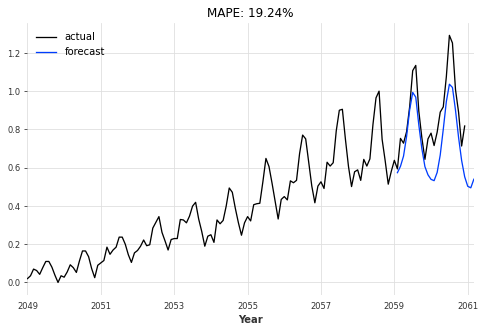

In [ ]:
eval_model(gru_model, 26, series_scaled, val_scaled)